Or, how to get thrown out of a casino because you're a mathematician.

---

In the ongoing eternal cycle of mathematicians asking generally useless questions about probability, I dreamt up another one. The scenario is as follows:

**You're playing a game with two die, and you do not get to see what the outcome of the die are on each roll. All you get to see is their sum. Given an arbitrarily long list of the sum of two rolls, can you determine if one or both die are loaded, and what those loadings are?**

# Proving we can detect cheating

My first question is simply, is this possible? There's a lot of trivial cases that make it obvious that there's cheating going on. But there are some edge cases that might give us more difficulty. First though, let's get a picture of what the fair distribution looks like. In principle, we can only detect cheating if the distribution of the fair die differs from the distribution of the loaded die.

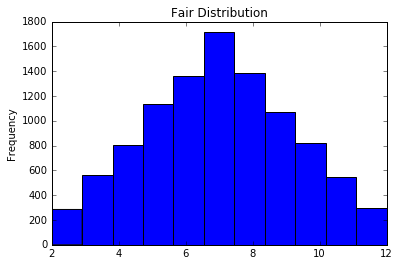

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fair_1 = np.random.randint(1, 7, 10000)
fair_2 = np.random.randint(1, 7, 10000)

pd.Series(fair_1 + fair_2).plot(kind='hist', bins=11);
plt.title('Fair Distribution');

This distribution makes sense: there are many ways to make a 7 (the most frequent observed value) and very few ways to make a 12 or 2; an important symmetry. As a special note, you can notice that the sum of two fair dice is a discrete case of the [Triangle Distribution][1], which is itself a special case of the [Irwin-Hall Distribution][2].

# The Edge Cases

Given that we understand how the results of two fair dice are distributed, let's see some of the interesting edge cases that come up. This will give us assurance that when a casino is cheating, it is detectable (given sufficient data). To make this as hard as possible, we will think of scenarios where the expected value of the sum of loaded dice is the same as the expected value of the sum of fair dice.

### Edge Case 1
What happens when one die is biased low, and one die is biased high? That is, where:

\begin{align}
\begin{array}{cc}
D_1 = \left\{
\begin{array}{lr}
1 & w.p. 1/3\\
2 & w.p. 1/3\\
3 & w.p. 1/12\\
4 & w.p. 1/12\\
5 & w.p. 1/12\\
6 & w.p. 1/12
\end{array}
\right. &
D_2 = \left\{
\begin{array}{lr}
1 & w.p. 1/12\\
2 & w.p. 1/12\\
3 & w.p. 1/12\\
4 & w.p. 1/12\\
5 & w.p. 1/3\\
6 & w.p. 1/3
\end{array}
\right. \\
\mathbb{E}[D_1] = 2.5 & \mathbb{E}[D_2] = 4.5
\end{array}\\
\mathbb{E}[D_1 + D_2] = 7 = \mathbb{E}[D_{fair} + D_{fair}]
\end{align}

[1]: https://en.wikipedia.org/wiki/Triangular_distribution
[2]: https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution

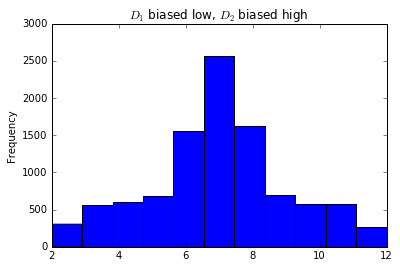

In [2]:
def unfair_die(p_vals, n):
    x = np.random.multinomial(1, p_vals, n)
    return x.nonzero()[1] + 1

d1 = [1/3, 1/3, 1/12, 1/12, 1/12, 1/12]
d2 = [1/12, 1/12, 1/12, 1/12, 1/3, 1/3]

x1 = unfair_die(d1, 10000)
x2 = unfair_die(d2, 10000)

pd.Series(x1 + x2).plot(kind='hist', bins=11);
plt.title('$D_1$ biased low, $D_2$ biased high');

We can see that while the 7 value remains the most likely (as expected), the distribution is not so nicely shaped any more. 

**Edge Case 2:** When one die is loaded low, and one is loaded high, we've seen how we can detect them. How about when two die are loaded both low and high? That is, we have the following distribution:

\begin{align}
\begin{array}{cc}
D_1 = \left\{
\begin{array}{lr}
1 & w.p. 1/3\\
2 & w.p. 1/12\\
3 & w.p. 1/12\\
4 & w.p. 1/12\\
5 & w.p. 1/12\\
6 & w.p. 1/3
\end{array}
\right. &
D_2 = \left\{
\begin{array}{lr}
1 & w.p. 1/3\\
2 & w.p. 1/12\\
3 & w.p. 1/12\\
4 & w.p. 1/12\\
5 & w.p. 1/12\\
6 & w.p. 1/3
\end{array}
\right. \\
\mathbb{E}[D_1] = 3.5 & \mathbb{E}[D_2] = 3.5
\end{array}\\
\mathbb{E}[D_1 + D_2] = 7 = \mathbb{E}[D_{fair} + D_{fair}]
\end{align}

We can see even that the expected value of each individual die is the same as the fair die! However, the distribution (if we are doing this correctly) should still be skewed:

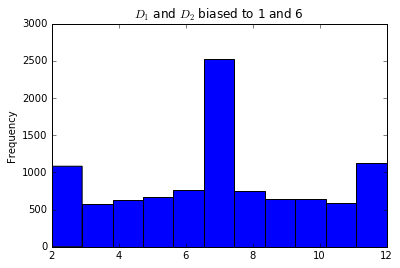

In [3]:
d1 = [1/3, 1/12, 1/12, 1/12, 1/12, 1/3]
d2 = d1

x1 = unfair_die(d1, 10000)
x2 = unfair_die(d2, 10000)

pd.Series(x1 + x2).plot(kind='hist', bins=11)
plt.title("$D_1$ and $D_2$ biased to 1 and 6");

In a very un-subtle way, we have of course made the values 2 and 12 far more likely.

# Detection Conclusion

There are some trivial examples of cheating that are easy to detect: whenever the expected value of the sum of two fair dice deviates from the expected value for the sum of two fair dice, we can immediately conclude that there is cheating at stake.

The interesting edge cases occur when the expected value of the sum of loaded dice matches the expected value of the sum of fair dice. Considering the above examples (and a couple more I ran through in developing this), we have seen that in every circumstance having two unfair dice leads to a distribution of results different from the fair results.

We can thus finally state: **just by looking at the distribution of results from this game, we can immediately conclude whether there is cheating.**

# Simulated Annealing

What we really would like to do though, is see if there is any way to determine how exactly the dice are loaded. This is significantly more complicated, but we can borrow some algorithms from Machine Learning to figure out exactly how to perform this process. I'm using the Simulated Annealing algorithm, and I discuss why this works and why I chose it over some of the alternatives in the [justification](#Justification-of-Simulated-Annealing). If you don't care about how I set up the model and just want to see the code, check out [the actual code](#The-actual-code).

[Simulated Annealing][3] is a variation of the [Metropolis-Hastings Algorithm][4], but the important thing for us is: Simulated Annealing allows us to quickly optimize high-dimensional problems. But what exactly are we trying to optimize? Ideally, we want a function that can tell us whether one distribution for the dice better explains the results than another distribution. This is known as the **likelihood** function.

## Deriving the Likelihood function

To derive our likelihood function, we want to know: **what is the probability of seeing a specific result given those hidden parameters?** This is actually a surprisingly difficult problem. While we can do a lot of calculations by hand, we need a more general solution since we will be working with very some interesting die distributions.

We first note that the sum of two dice can take on 11 different values - 2 through 12. This implies that each individual sum follows a [Categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution). That is:

\begin{align}
\mathcal{L(x)} = \left\{
\begin{array}{lr}
p_2 & x = 2\\
p_3 & x = 3\\
\ldots & \\
p_{11} & x = 11\\
p_{12} & x = 12
\end{array}
\right.
\end{align}

Where each $p_i$ is the probability of seeing that specific result. However, we need to calculate what each probability is! I'll save you the details, but [this author](http://math.stackexchange.com/a/1646360/320784) explains how to do it.

Now, we would like to know the likelihood of our entire data-set. This is trivial:

\begin{align}
\mathcal{L(\mathbf{X})} &= \prod_{i=1}^n L(x)
\end{align}

However, it's typically much easier to work with the $\log(\mathcal{L})$ function instead. This is critically important from a computational perspective: when you multiply so many small numbers together (i.e. the product of $L(x)$ terms) the computer suffers from rounding error; if we don't control for this, we will find that no matter the distributions we choose for each die, the "likelihood" will be close to zero because the computer is not precise enough.

\begin{align}
\log(\mathcal{L}) &= \sum_{i=1}^n \log(L)
\end{align}

## The process of Simulated Annealing

The means by which we optimize our likelihood function is the simulated annealing algorithm. The way it works is as follows:

1. Start with a random guess for the parameters we are trying to optimize. In our case we are trying to guess the distribution of two dice, and so we "optimize" until we have a distribution that matches the data.

2. For each iteration of the algorithm:

    1. Generate a new "proposed" set of parameters based on the current parameters -
    i.e. slightly modify the current parameters to get a new set of parameters.
    2. Calculate the value of $\log(\mathcal{L})$ for each set of parameters. If the function value for the
    proposed parameter set is higher than for the current, automatically switch to the new parameter set
    and continue the next iteration.
    3. Given the new parameter set performs worse, determine a probability of switching to the new parameter set anyways: $\mathcal{P}(p_{current}, p_{proposed})$
    4. Switch to the new parameter set with probability $\mathcal{P}$. If you fail to switch, begin the next iteration.
    
3. The algorithm is complete after we fail to make a transition $n$ times in a row.

If everything goes according to plan, we will have a value that is close to the true distribution of each die.

# The actual code

We start by defining the score function. This will tell us how well the proposed die densities actually explain the results.

[3]:https://en.wikipedia.org/wiki/Simulated_annealing
[4]:https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

In [5]:
import numpy as np
from numpy import polynomial

def density_coef(d1_density, d2_density):
    # Calculating the probabilities of each outcome was taken
    # from this author: http://math.stackexchange.com/a/1710392/320784
    d1_p = polynomial.Polynomial(d1_density)
    d2_p = polynomial.Polynomial(d2_density)
    coefs = (d1_p * d2_p).coef
    return coefs

def score(x, d1_density, d2_density):
    # We've now got the probabilities of each event, but we need
    # to shift the array a bit so we can use the x values to actually
    # index into it. This will allow us to do all the calculations
    # incredibly quickly
    coefs = density_coef(d1_density, d2_density)
    coefs = np.hstack((0, 0, coefs))
    return np.log(coefs[x]).sum()

Afterward, we need to write something to permute the proposal densities. We make random modifications, and eventually the best one survives.

In [6]:
def permute(d1_density, d2_density):
    # To ensure we have legitimate densities, we will randomly
    # increase one die face probability by `change`,
    # and decrease one by `change`.
    # This means there are something less than (1/`change`)^12 possibilities
    # we are trying to search over.
    change = .01
    
    d1_index1, d1_index2 = np.random.randint(0, 6, 2)
    d2_index1, d2_index2 = np.random.randint(0, 6, 2)
    
    # Also make sure to copy. I've had some weird aliasing issues
    # in the past that made everything blow up.
    new_d1 = np.float64(np.copy(d1_density))
    new_d2 = np.float64(np.copy(d2_density))
    
    # While this doesn't account for the possibility that some
    # values go negative, in practice this never happens
    new_d1[d1_index1] += change
    new_d1[d1_index2] -= change
    new_d2[d2_index1] += change
    new_d2[d2_index2] -= change
    
    return new_d1, new_d2

Now we've got the main algorithm code to do. This is what brings all the pieces together.

In [7]:
def optimize(data, conv_count=10, max_iter=1e4):
    switch_failures = 0
    iter_count = 0
    
    # Start with guessing fair dice
    cur_d1 = np.repeat(1/6, 6)
    cur_d2 = np.repeat(1/6, 6)
    cur_score = score(data, cur_d1, cur_d2)
    
    # Keep track of our best guesses - may not be
    # what we end with
    max_score = cur_score
    max_d1 = cur_d1
    max_d2 = cur_d2
    
    # Optimization stops when we have failed to switch `conv_count`
    # times (presumably because we have a great guess), or we reach
    # the maximum number of iterations.
    while switch_failures < conv_count and iter_count < max_iter:
        iter_count += 1
        if iter_count % (max_iter / 10) == 0:
            print('Iteration: {}; Current score (higher is better): {}'.format(
                    iter_count, cur_score))
                
        new_d1, new_d2 = permute(cur_d1, cur_d2)
        new_score = score(data, new_d1, new_d2)
        
        if new_score > max_score:
            max_score = new_score
            max_d1 = new_d1
            max_d2 = new_d2
            
        if new_score > cur_score:
            # If the new permutation beats the old one,
            # automatically select it.
            cur_score = new_score
            cur_d1 = new_d1
            cur_d2 = new_d2
            switch_failures = 0
        else:
            # We didn't beat the current score, but allow
            # for possibly switching anyways.
            accept_prob = np.exp(new_score - cur_score)
            coin_toss = np.random.rand()
            if coin_toss < accept_prob:
                # We randomly switch to the new distribution
                cur_score = new_score
                cur_d1 = new_d1
                cur_d2 = new_d2
                switch_failures = 0
            else:
                switch_failures += 1
            
    # Return both our best guess, and the ending guess
    return max_d1, max_d2, cur_d1, cur_d2

And now we have finished the hard work!

# Catching the Casino

Let's go through a couple of scenarios and see if we can catch the casino cheating with some loaded dice. **In every scenario we start with an assumption of fair dice**, and then try our hand to figure out what the *actual* distribution was.

## Attempt 1


The casino is using two dice that are both biased low. How well can we recover the distribution?

Iteration: 1000; Current score (higher is better): -22147.004400281654
Simulated Annealing time: 0.30s


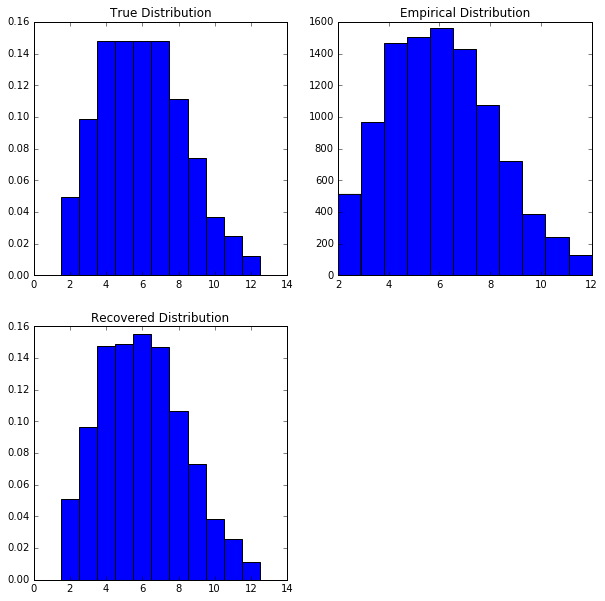

In [8]:
import time
def simulate_casino(d1_dist, d2_dist, n=10000):
    d1_vals = unfair_die(d1_dist, n)
    d2_vals = unfair_die(d2_dist, n)
    
    start = time.perf_counter()
    max_d1, max_d2, final_d1, final_d2 = optimize(d1_vals + d2_vals)
    end = time.perf_counter()
    print("Simulated Annealing time: {:.02f}s".format(end - start))
    
    coef_range = np.arange(2, 13) - .5
    plt.subplot(221)
    plt.bar(coef_range, density_coef(d1_dist, d2_dist), width=1)
    plt.title('True Distribution')
    
    plt.subplot(222)
    plt.hist(d1_vals + d2_vals, bins=11)
    plt.title('Empirical Distribution')
    
    plt.subplot(223)
    plt.bar(coef_range, density_coef(max_d1, max_d2), width=1)
    plt.title('Recovered Distribution')
    
    plt.gcf().set_size_inches(10, 10)


simulate_casino([2/9, 2/9, 2/9, 1/9, 1/9, 1/9],
                [2/9, 2/9, 2/9, 1/9, 1/9, 1/9])

## Attempt 2

The casino now uses dice that are both biased towards 1 and 6.

Simulated Annealing time: 0.08s


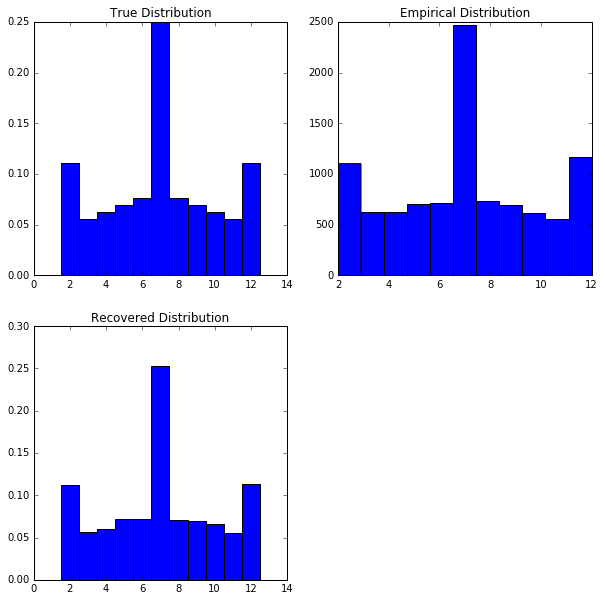

In [9]:
simulate_casino([1/3, 1/12, 1/12, 1/12, 1/12, 1/3],
                [1/3, 1/12, 1/12, 1/12, 1/12, 1/3])

## Attempt 3

The casino will now use one die biased towards 1 and 6, and one die towards 3 and 4.

Simulated Annealing time: 0.09s


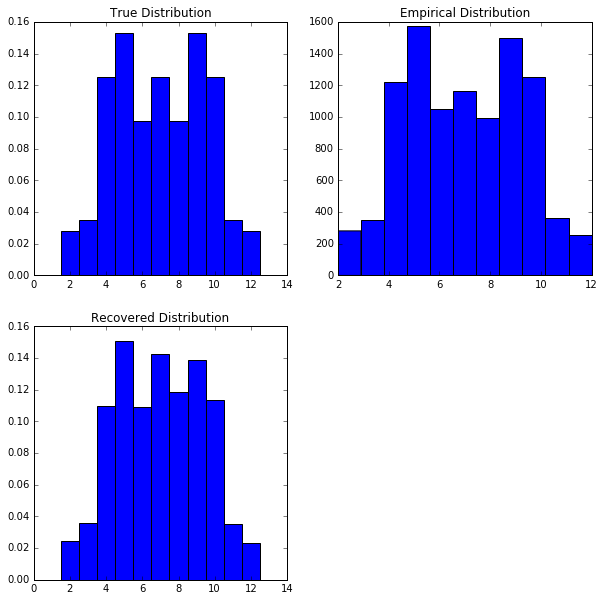

In [10]:
simulate_casino([1/3, 1/12, 1/12, 1/12, 1/12, 1/3],
                [1/12, 1/12, 1/3, 1/3, 1/12, 1/12])

## Attempt 4

We'll now finally go to a fair casino to make sure that we can still recognize a positive result.

Simulated Annealing time: 0.02s


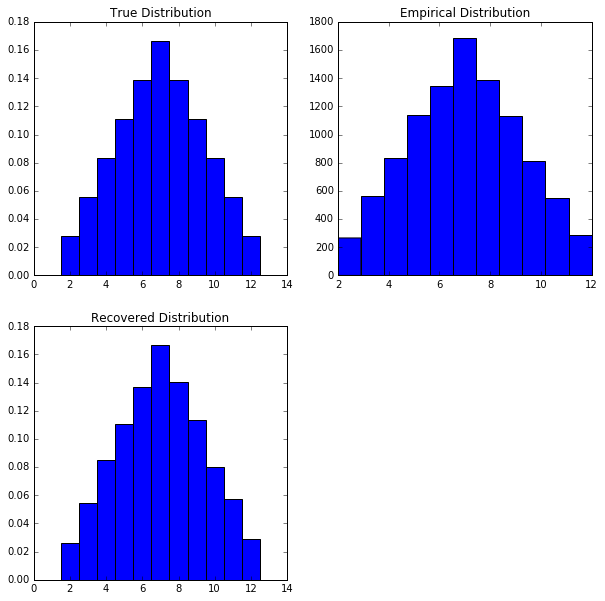

In [11]:
simulate_casino(np.repeat(1/6, 6), np.repeat(1/6, 6))

## Attempt 5

We've so far been working with a large amount of data - 10,000 data points. Can we now scale things back to only 250 throws? We'll start with two dice biased high.

Iteration: 1000; Current score (higher is better): -551.6995384525453
Iteration: 2000; Current score (higher is better): -547.7803673440676
Iteration: 3000; Current score (higher is better): -547.9805613193807
Iteration: 4000; Current score (higher is better): -546.7574874775273
Iteration: 5000; Current score (higher is better): -549.5798007672656
Iteration: 6000; Current score (higher is better): -545.0354060154496
Iteration: 7000; Current score (higher is better): -550.1134504086606
Iteration: 8000; Current score (higher is better): -549.9306537114975
Iteration: 9000; Current score (higher is better): -550.7075182119111
Iteration: 10000; Current score (higher is better): -549.400679551826
Simulated Annealing time: 1.94s


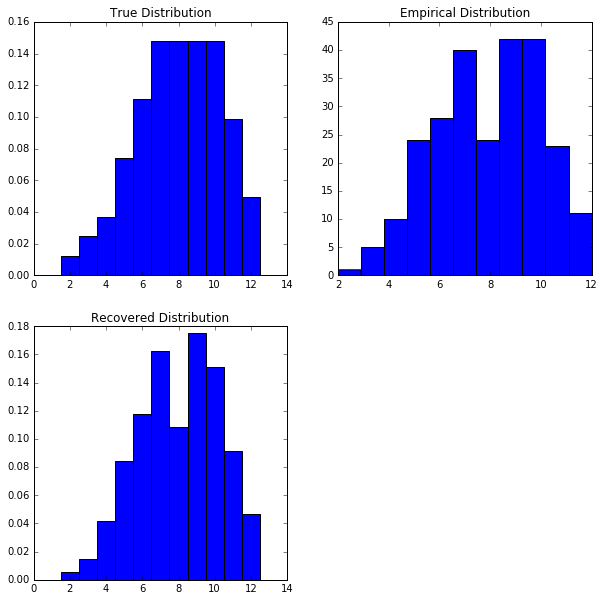

In [12]:
simulate_casino([1/9, 1/9, 1/9, 2/9, 2/9, 2/9],
                [1/9, 1/9, 1/9, 2/9, 2/9, 2/9],
                n=250)

The results are surprisingly good. While the actual optimization process took much longer to finish than in the other examples, we still have a very good guess. As a caveat though: the recovered distribution tends to overfit the data. That is, if the data doesn't fit the underlying distribution well, the model will also fail.

# Conclusion

Given the results above, we can see that we have indeed come up with a very good algorithm to determine the distribution of two dice given their results. As a benefit, we have even seen that results come back very quickly; it's not uncommon for the optimization to converge within a tenth of a second.

Additionally, we have seen that the algorithm can intuit the distribution even when there is not much data. While the final example shows that we can 'overfit' on the dataset, we can still get valuable information from a relatively small dataset.

We can declare at long last: **the mathematicians have again triumphed over the casino**.

---

# Justification of Simulated Annealing

## Why Simulated Annealing?

So why even use an algorithm with a fancy title like Simulated Annealing? First of all, because the title is sexy. Second of all, because this is a reasonably complicated problem to try and solve. We have a parameter space where each value $p_{ij} \in (0, 1); i, j \in \{1, \ldots, 6\}$, for a total of 12 different variables we are trying to optimize over. Additionally, given a 12-dimensional function we are trying to optimize, simulated annealing makes sure that we don't fall into a local minimum.

## Why not something else?

This is a fair question. There are two classes of algorithms that can also be used to solve this problem: [Non-linear optimization](https://en.wikipedia.org/wiki/Nonlinear_programming) methods, and the [EM algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

1. I chose not to use non-linear optimization simply because I'm a bit concerned that it will trap me in a local maximum. Instead of running multiple different optimizations from different starting points, I can just use simulated annealing to take that into account. In addition, throughout the course of testing the simulated annealing code converged *incredibly* quickly - far more quickly than any non-linear solver would be able to accomplish. 

2. The EM Algorithm was originally what I intended to write this blog post with. Indeed, the post was inspired by the [crooked casino](http://web.stanford.edu/class/stats366/hmmR2.html) example which uses the EM algorithm to solve it. However, after modeling the likelihood function I realized that the algebra would very quickly get out of hand. Trying to compute all the polynomial terms would not be fun, which would be needed to actually optimize for each parameter. So while the EM algorithm would likely be much faster in raw speed terms, the amount of time needed to program and verify it meant that I was far better off using a different method for optimization.